In [ ]:
"""
NOTES:
    - this notebook has two parts:
        (1) clean the `reference`, or the raw, unannotated documents
        (2) map the annotations back onto this reference
    - accuracy is more important than speed
"""

In [6]:
import sys
import os
import json
import pandas as pd
import hashlib
import numpy as np
import spacy
import re
import random
from importlib import reload
from datetime import datetime
from collections import defaultdict
from pprint import pprint
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

#local
import utility_funcs

In [2]:
%matplotlib inline

In [7]:
nlp = spacy.load('en_core_web_lg')

## Parse Unannotated Documents

In [8]:
reload(utility_funcs)

def cosemetic_clean(document):
    """A function to perform minor text processing
    in hopes of making sentence parsing more robust
    
    Args:
        - document (str): a document
        
    Returns:
        clean_document (str): a document with minor adjustments    
    """
    decoded_doc = utility_funcs.force_encoding(document)
    clean_document = re.sub(' +', ' ', decoded_doc).replace("_", "")
    return clean_document
    
    
def parse_documents(d_map):
    """A function to add parsed documents to dmap
    
    NOTE: modifies `d_map` in place, does not make a copy
    
    Args:
        - d_map (dict): a document map created in the preprocessing
            step
            
    Returns:
        - d_map (dict): a document map created in the preprocessing
            step
    """
    for ICD_id, content in d_map.items():
        pre_parse = cosemetic_clean(content['raw_content'])
        parsed = nlp(pre_parse)
        sentences = list(parsed.sents)
        
        content['parsed'] = parsed
        content['sentences'] = sentences
        
    return d_map

In [9]:
%time
d_map_path = "processed_annotations/DOCUMENT_MAP_02-14-2020.json"
d_map = json.load(open(d_map_path))

d_map = parse_documents(d_map)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 27.9 µs


In [10]:
d_map['10932687'].keys()

dict_keys(['raw_content', 'from_file', 'parsed', 'sentences'])

In [11]:
"""
I'll build a reference data frame with all sentences
"""
new_rows = []

for ICD_id, content in d_map.items():
    for sent in content['sentences']:
        
        row = {
            'ICD_doc_id':str(ICD_id),
            'sentece': sent.text,
            'start_pos':sent.start_char,
            'num_words':len(sent),
            'num_chars':len(sent.text),
            'sentece_obj': sent,
        }
        new_rows.append(row)
        
ref = pd.DataFrame(new_rows)
ref.head()

,ICD_doc_id,sentece,start_pos,num_words,num_chars,sentece_obj
0,95581557,Ct) MERCY HEALTH \n,0,5,18,"(Ct, ), MERCY, HEALTH, \n)"
1,95581557,"GRAND RAPIDS,",18,3,13,"(GRAND, RAPIDS, ,)"
2,95581557,Ml \nCONSENT,32,3,11,"(Ml, \n, CONSENT)"
3,95581557,TO RECEIVE \n,44,3,12,"(TO, RECEIVE, \n)"
4,95581557,Patient Label \n\nNON-EMERGENCY TRANSFUSION OF...,56,9,50,"(Patient, Label, \n\n, NON, -, EMERGENCY, TRAN..."


In [12]:
"""
save the reference
"""
ref.to_csv("processed_annotations/reference.csv", index=False)

## Load (and save) Annotations

In [13]:
"""
Load the preprocessed annotations
"""

df = pd.read_csv("processed_annotations/ANNOTATIONS_02-14-2020.csv")
df.head()

,ICD_doc_id,json_filename,annotator,annotation_id,A,B,C,start_char,end_char,text,sentence_count
0,95581557,../data/2020-01-21_Random_46-60_KATHLEEN.json,KATHLEEN,22668539,1,0,0,2613,2795,"By signing this form, I am requesting and givi...",1
1,95581557,../data/2020-01-21_Random_46-60_KATHLEEN.json,KATHLEEN,66236403,0,0,1,366,558,I understand that blood or blood products will...,1
2,95581557,../data/2020-01-21_Random_46-60_KATHLEEN.json,KATHLEEN,66236403,0,0,1,366,558,My doctor will determine the amount of blood o...,2
3,69408590,../data/2020-01-21_Random_46-60_KATHLEEN.json,KATHLEEN,97685314,1,0,0,323,516,I authorize the release of any and all medical...,1
4,69408590,../data/2020-01-21_Random_46-60_KATHLEEN.json,KATHLEEN,39472471,1,0,0,104,321,I voluntarily consent to medical care of a rou...,1


In [18]:
# """
# Save all A or B annotations by annotator
# """

# for annotator in set(df.annotator):
#     annotator_df = df[(df.annotator == f"{annotator}") & ((df.A == 1) | (df.B == 1))]
#     annotator_df.to_csv(f"processed_annotations/{annotator}_AB_only.csv", index=False)

## Align these puppies

In [14]:
ref.dtypes

ICD_doc_id     object
sentece        object
start_pos       int64
num_words       int64
num_chars       int64
sentece_obj    object
dtype: object

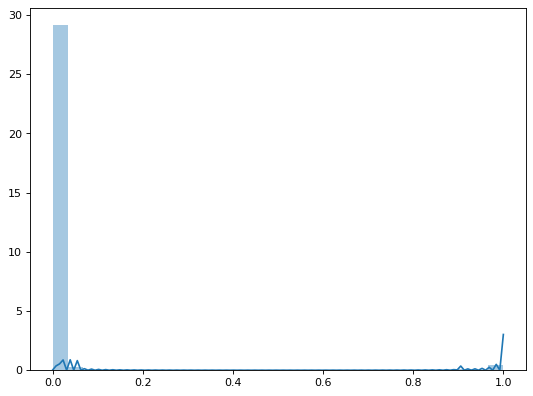

In [123]:
new_rows = []


def score_pair(reference__sentence, annotated_sentence):
    """A function to score a pair of sentences for similarity
    
    Args:
        - reference__sentence (str): the reference sentence
        - annotated_sentence (str): the canndidate sentence (annotation)
        
    Returns:
        - score (float): a likelihood that the sentences are the same
    """
    
    
    ## TODO: need to handle empty vectors
    sim = nlp(reference__sentence).similarity(nlp(annotated_sentence))
    len_dff_sq = (len(reference__sentence) - len(annotated_sentence))**2
    if len_dff_sq == 0:
        len_dff_sq = 1
    
    len_weighted_sim = (1/len_dff_sq)*sim
    
    return len_weighted_sim
    

random_doc = random.sample(d_map.keys(), 1)[0]
    
for idx, ref_row in ref[ref.ICD_doc_id == random_doc].iterrows():
    scores = []
    
    reference_sent = ref_row['sentece']     
    inter_doc_annotations = df[df['ICD_doc_id'] == int(ref_row['ICD_doc_id'])]
    
    for aidx, annotation_row in inter_doc_annotations.iterrows():
        annotated_text = annotation_row['text']
#         print(f"score: {score_pair(reference_sent, annotated_text)}")
#         print(f"\tREFERNCE: {reference_sent.strip()}")
#         print(f"\tANNOTATION: {annotated_text.strip()}")
#         print()

        scores.append(score_pair(reference_sent, annotated_text))
    
    """
    if max score > THRESHOLD:
        add annotation data and other data to new_rows
    else:
        move on
    """
    
